# Connect and Import

In [ ]:
# Connect google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip install opencv-python-headless mediapipe

In [ ]:
import cv2
import os
import random
import shutil
import mediapipe as mp
import pickle

from PIL import Image
from torchvision import transforms
from concurrent.futures import ThreadPoolExecutor
from threading import Lock

# Preprocessing

## Frames extraction

In [ ]:
!cp /content/drive/MyDrive/deepfake_ds/Celeb-DF-v2.zip /content/
!unzip /content/Celeb-DF-v2.zip -d /content/CelebDF

First step of the pipeline is to extract 20 frames per video.

In [ ]:
# Lock to protect access to log file (for multithreading)
log_lock = Lock()

def preprocess_database():
    base_folder = '/content/CelebDF/Celeb-DF-v2'
    output_base_folder = '/content/modeep_dataset'
    full_frames_base_folder = '/content/full_frames'
    log_path = '/content/processed_videos.txt'                                  # File di log

    os.makedirs(output_base_folder, exist_ok=True)
    os.makedirs(full_frames_base_folder, exist_ok=True)

    # Divide in real and fake subfolder
    real_full_frames_folder = os.path.join(full_frames_base_folder, 'real')
    fake_full_frames_folder = os.path.join(full_frames_base_folder, 'fake')
    os.makedirs(real_full_frames_folder, exist_ok=True)
    os.makedirs(fake_full_frames_folder, exist_ok=True)

    real_res_frames_folder = os.path.join(output_base_folder, 'real')
    fake_res_frames_folder = os.path.join(output_base_folder, 'fake')
    os.makedirs(real_res_frames_folder, exist_ok=True)
    os.makedirs(fake_res_frames_folder, exist_ok=True)

    # Load already processed video list
    processed_files = load_processed_log(log_path)
    video_tasks = []

    folders = ['Celeb-real', 'Celeb-synthesis', 'YouTube-real']

    # Configure directories and video to process
    for folder in folders:
        input_path = os.path.join(base_folder, folder)
        if folder in ['Celeb-real', 'YouTube-real']:
            resized_output_folder = real_res_frames_folder
            full_output_folder = real_full_frames_folder
        elif folder == 'Celeb-synthesis':
            resized_output_folder = fake_res_frames_folder
            full_output_folder = fake_full_frames_folder
        else:
            continue

        for video_file in os.listdir(input_path):
            if video_file.endswith('.mp4') and video_file not in processed_files:
                video_path = os.path.join(input_path, video_file)
                video_tasks.append((video_path, resized_output_folder, full_output_folder))
                print(f"Total video ready to process: {len(video_tasks)}")

    # Execute video processing with 2 threads
    with ThreadPoolExecutor(max_workers=2) as executor:                         # Colab base consente 2 thread
        futures = [executor.submit(process_video, task, log_path) for task in video_tasks]
        for future in futures:
            future.result()

def process_video(task, log_path):
    video_path, resized_output_folder, full_output_folder = task
    video_file = os.path.basename(video_path)

    # Extract frames
    extract_frames(video_path, resized_output_folder, full_output_folder)

    # Refresh log
    with log_lock:
        with open(log_path, 'a') as log_file:
            log_file.write(f"{video_file}\n")
        print(f"Video processed and added to the log file: {video_file}")

def extract_frames(video_path, resized_output_folder, full_output_folder, num_frames=20):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Impossible to open the video {video_path}")
        return

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_rate = max(total_frames // num_frames, 1)

    video_name = os.path.splitext(os.path.basename(video_path))[0]
    for i in range(num_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * frame_rate)
        ret, frame = cap.read()
        if ret:
            # Salva il frame completo (full frames)
            full_frame_filename = os.path.join(full_output_folder, f"{video_name}_frame_{i}.jpg")
            cv2.imwrite(full_frame_filename, frame)

            # Salva il frame ridimensionato
            resized_frame = cv2.resize(frame, (224, 224), interpolation=cv2.INTER_AREA)
            resized_frame_filename = os.path.join(resized_output_folder, f"{video_name}_frame_{i}.jpg")
            cv2.imwrite(resized_frame_filename, resized_frame)
        else:
            print(f"Error in the frame {i} from video {video_path}")
    cap.release()

def load_processed_log(log_path):
    if os.path.exists(log_path):
        with open(log_path, 'r') as f:
            return set(f.read().splitlines())
    return set()

# Start preprocessing
preprocess_database()


Check files

In [ ]:
!find /content/modeep_dataset_2 -type f -name "*.jpg" | wc -l
!find /content/full_frames -type f -name "*.jpg" | wc -l

130603


Google Drive Copy

In [ ]:
import shutil
import os

# Local paths
local_full_frames = '/content/full_frames'
local_modeep_dataset = '/content/modeep_dataset'

# .zip paths
zip_full_frames = '/content/full_frames.zip'
zip_modeep_dataset = '/content/modeep_dataset.zip'

# Google Drive path
drive_folder = '/content/drive/MyDrive/deepfake_ds'

# Destination path check
os.makedirs(drive_folder, exist_ok=True)

# Folder zip
print("Compression of the directories...")
shutil.make_archive(zip_full_frames.replace('.zip', ''), 'zip', local_full_frames)
shutil.make_archive(zip_modeep_dataset.replace('.zip', ''), 'zip', local_modeep_dataset)
print("Compression completed")

# Upload zip file
os.system(f"cp {zip_full_frames} {drive_folder}")
os.system(f"cp {zip_modeep_dataset} {drive_folder}")
print("Upload on Google Drive completed")


## ROI extraction

Download and unzip from Google Drive

In [ ]:
!cp /content/drive/MyDrive/deepfake_ds/modeep_dataset.zip /content/
!unzip /content/modeep_dataset.zip -d /content/modeep_dataset

In [ ]:
!cp /content/drive/MyDrive/deepfake_ds/full_frames.zip /content/
!unzip /content/full_frames.zip -d /content/full_frames

Next step of the pipeline is to extract an image for each region of interest (ROI) from each frame, then resize to 64x64 dimension.

In [ ]:
# Initializa Mediapipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

# Landmark Mediapipe for each region of interest (ROI)
eye_landmarks = [33, 133, 160, 144, 158, 153, 362, 263, 387, 373, 380, 385]
nose_landmarks = [1, 2, 98, 327, 4, 5, 6, 195, 197, 4]
mouth_landmarks = [61, 291, 185, 40, 39, 146, 91, 181, 84, 17, 314, 405]

# Directories
input_base_folder = '/content/full_frames'
output_base_folder = '/content/modeep_dataset'
log_path = '/content/processed_roi_log.txt'                                     # Log File
os.makedirs(output_base_folder, exist_ok=True)

# Load already processed files list
def load_processed_log(log_path):
    if os.path.exists(log_path):
        with open(log_path, 'r') as f:
            return set(f.read().splitlines())
    return set()

# Function to crop region of interest
def crop_region(points, img):
    h, w, _ = img.shape
    x_min = max(0, int(min(points, key=lambda p: p.x).x * w))
    x_max = min(w, int(max(points, key=lambda p: p.x).x * w))
    y_min = max(0, int(min(points, key=lambda p: p.y).y * h))
    y_max = min(h, int(max(points, key=lambda p: p.y).y * h))
    return img[y_min:y_max, x_min:x_max]

# Function to elaborate a frame
def process_frame(image_path, output_folder, log_path):
    video_name = os.path.basename(image_path).split('_frame_')[0]
    frame_idx = os.path.basename(image_path).split('_frame_')[-1].split('.')[0]

    # Skip if already processed frame
    if os.path.exists(os.path.join(output_folder, f"{video_name}_mouth_{frame_idx}.jpg")):
        return

    img = cv2.imread(image_path)
    if img is None:
        print(f"Error in image reading: {image_path}")
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(img_rgb)
    if not results.multi_face_landmarks:
        print(f"No face detected: {image_path}")
        return

    face_landmarks = results.multi_face_landmarks[0]
    try:
        eyes = crop_region([face_landmarks.landmark[i] for i in eye_landmarks], img)
        nose = crop_region([face_landmarks.landmark[i] for i in nose_landmarks], img)
        mouth = crop_region([face_landmarks.landmark[i] for i in mouth_landmarks], img)

        eyes = cv2.resize(eyes, (64, 64))
        nose = cv2.resize(nose, (64, 64))
        mouth = cv2.resize(mouth, (64, 64))

        # Salva i file direttamente nella cartella real o fake
        cv2.imwrite(os.path.join(output_folder, f"{video_name}_eyes_{frame_idx}.jpg"), eyes)
        cv2.imwrite(os.path.join(output_folder, f"{video_name}_nose_{frame_idx}.jpg"), nose)
        cv2.imwrite(os.path.join(output_folder, f"{video_name}_mouth_{frame_idx}.jpg"), mouth)

        # Aggiorna il log in modo thread-safe
        with log_lock:
            with open(log_path, 'a') as log_file:
                log_file.write(f"{image_path}\n")
        print(f"Frame {frame_idx} of video {video_name} processed.")
    except Exception as e:
        print(f"Error during saving: {e}")

# Funzione principale per il processamento sequenziale
def process_all_frames(input_base_folder, output_base_folder, log_path):
    processed_files = load_processed_log(log_path)

    # Scansiona le cartelle di input (real e fake)
    for category in ['real', 'fake']:
        input_folder = os.path.join(input_base_folder, category)
        output_folder = os.path.join(output_base_folder, category)
        os.makedirs(output_folder, exist_ok=True)

        for root, _, files in os.walk(input_folder):
            for file in files:
                if file.endswith('.jpg'):
                    image_path = os.path.join(root, file)
                    if image_path not in processed_files:
                        process_frame(image_path, output_folder, log_path)

# Avvia il processamento
process_all_frames(input_base_folder, output_base_folder, log_path)


## Utility and upload

In [ ]:
# Directories
base_folder = '/content/modeep_dataset_2'
real_folder = os.path.join(base_folder, 'real')
fake_folder = os.path.join(base_folder, 'fake')
summary_file = os.path.join(base_folder, 'dataset_summary.txt')

# Create a dictionary to count complete files (20 frames and 60 roi for each video)
def count_frames_summary(folder, class_label):
    video_info = {}
    complete_videos = []

    for file in sorted(os.listdir(folder)):                                     # Sort files
        if file.endswith('.jpg'):
            video_name = "_".join(file.split('_')[:-2])                         # Extract video name
            if video_name not in video_info:
                video_info[video_name] = {"frames": 0, "roi": 0}

            if 'frame' in file:
                video_info[video_name]["frames"] += 1
            elif any(tag in file for tag in ['eyes', 'nose', 'mouth']):
                video_info[video_name]["roi"] += 1

    # Create a list with all frames and ROI and count valid videos
    for video_name, counts in video_info.items():
        if counts["frames"] == 20 and counts["roi"] == 60:
            complete_videos.append(f"{video_name},{class_label}\n")

    return complete_videos, len(complete_videos)

# Create summary
real_summary, real_count = count_frames_summary(real_folder, "real")
fake_summary, fake_count = count_frames_summary(fake_folder, "fake")

# Write final summary
with open(summary_file, 'w') as f:
    f.writelines(real_summary + fake_summary)

# Print results
total_videos = real_count + fake_count
print(f"Complete videos (no missing images): {total_videos}")
print(f"'real' class videos: {real_count}")
print(f"'fake' class videos: {fake_count}")
print(f"Summary created: {summary_file}")

Compress and Drive upload

In [ ]:
# Directories
output_base_folder = '/content/modeep_dataset'
drive_folder = '/content/drive/MyDrive/deepfake_ds'
zip_name = 'modeep_dataset_complete'  # Nome del file ZIP

os.makedirs(drive_folder, exist_ok=True)

# Zippa la cartella modeep_dataset
print("Compression of modeep_dataset...")
shutil.make_archive(f"/content/{zip_name}", 'zip', output_base_folder)
print(f"Compression completed: /content/{zip_name}.zip")

# Carica il file ZIP su Google Drive
print("Uploading on Google Drive...")
os.system(f"cp /content/{zip_name}.zip {drive_folder}")
print(f"Succesfully uploaded: {drive_folder}/{zip_name}.zip")


Use in case of missing sync with Google Drive

In [ ]:
import subprocess

# Sync with Google Drive
print("Sync with Drive...")
subprocess.run(["sync"])
print("Sync completed")

# Datasets creation

In [ ]:
!cp /content/drive/MyDrive/deepfake_ds/modeep_dataset_complete.zip /content/
!unzip /content/modeep_dataset_complete.zip -d /content/ds_full

## Train Test and Val

Next step is to create train, test and validation datasets with proper proportions.

In [ ]:
# Directories
summary_file = '/content/ds_full/dataset_summary.txt'
output_folder = '/content/ds_split'
train_file = os.path.join(output_folder, 'train_ds.txt')
test_file = os.path.join(output_folder, 'test_ds.txt')
val_file = os.path.join(output_folder, 'val_ds.txt')

os.makedirs(output_folder, exist_ok=True)

# Proportions for train, test and val datasets
train_ratio = 0.7
test_ratio = 0.2
val_ratio = 0.1

# Create dataset based on dataset_summary.txt
with open(summary_file, 'r') as f:
    lines = f.readlines()

# Classes
real_videos = [line for line in lines if 'real' in line]
fake_videos = [line for line in lines if 'fake' in line]

# Function to divide dataset in train, test e val
def split_dataset(dataset, train_ratio, test_ratio, val_ratio):
    random.shuffle(dataset)  # Mescola i dati
    total = len(dataset)
    train_split = int(total * train_ratio)
    test_split = int(total * test_ratio)

    train_set = dataset[:train_split]
    test_set = dataset[train_split:train_split + test_split]
    val_set = dataset[train_split + test_split:]

    return train_set, test_set, val_set

# Split by class ratio adn combine
train_real, test_real, val_real = split_dataset(real_videos, train_ratio, test_ratio, val_ratio)
train_fake, test_fake, val_fake = split_dataset(fake_videos, train_ratio, test_ratio, val_ratio)

train_set = train_real + train_fake
test_set = test_real + test_fake
val_set = val_real + val_fake

# Shuffle
random.shuffle(train_set)
random.shuffle(test_set)
random.shuffle(val_set)

# Save lists in .txt
with open(train_file, 'w') as f:
    f.writelines(train_set)

with open(test_file, 'w') as f:
    f.writelines(test_set)

with open(val_file, 'w') as f:
    f.writelines(val_set)

# Final count
print(f"Train set: {len(train_set)} videos")
print(f"Test set: {len(test_set)} videos")
print(f"Val set: {len(val_set)} videos")


Verify labels proportions in train, test and val datasets

In [ ]:
# Function to count labels 'real' or 'fake'
def count_classes(dataset):
    real_count = sum(1 for line in dataset if 'real' in line)
    fake_count = sum(1 for line in dataset if 'fake' in line)
    return real_count, fake_count

# Count labels in each dataset
train_real, train_fake = count_classes(train_set)
test_real, test_fake = count_classes(test_set)
val_real, val_fake = count_classes(val_set)

# Print count
print(f"Train set: {train_real} real, {train_fake} fake")
print(f"Test set: {test_real} real, {test_fake} fake")
print(f"Val set: {val_real} real, {val_fake} fake")


Train set: 578 real, 3789 fake
Test set: 165 real, 1082 fake
Val set: 83 real, 543 fake


## Normalization and Tensors

In this step, we need to normalize images and convert to tensor to make them ready for training dataset

In [ ]:
# Function to preprocess an image with the chosen transform
def preprocess_image(image_path, transform):
    try:
        image = Image.open(image_path).convert("RGB")
        image = transform(image)
        return image
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Function to create a dataset with ROI in pickles files
def create_dataset(data_list_path, data_dir_real, data_dir_fake, transform_roi, batch_size=100, output_dir="/content/ds_split"):
    os.makedirs(output_dir, exist_ok=True)
    skipped_videos = 0                                                          # Counter for skipped videos
    dataset = []                                                                # Temp list for batch
    batch_count = 0                                                             # Batch counter

    with open(data_list_path, 'r') as f:
        video_list = f.read().splitlines()

    for idx, line in enumerate(video_list, start=1):
        video_name, label = line.split(",")
        label = 0 if label == "real" else 1
        data_dir = data_dir_real if label == 0 else data_dir_fake

        video_data = {
            "video_name": video_name,
            "eyes": [],
            "nose": [],
            "mouth": [],
            "label": label
        }

        # Iterate over 20 frames
        for i in range(20):
            eyes_path = os.path.join(data_dir, f"{video_name}_eyes_{i}.jpg")
            nose_path = os.path.join(data_dir, f"{video_name}_nose_{i}.jpg")
            mouth_path = os.path.join(data_dir, f"{video_name}_mouth_{i}.jpg")

            eyes_tensor = preprocess_image(eyes_path, transform_roi)
            nose_tensor = preprocess_image(nose_path, transform_roi)
            mouth_tensor = preprocess_image(mouth_path, transform_roi)

            if eyes_tensor is not None:
                video_data["eyes"].append(eyes_tensor)
            if nose_tensor is not None:
                video_data["nose"].append(nose_tensor)
            if mouth_tensor is not None:
                video_data["mouth"].append(mouth_tensor)

        # Filter for uncomplete videos (less than 20 roi)
        if len(video_data["eyes"]) < 20 or len(video_data["nose"]) < 20 or len(video_data["mouth"]) < 20:
            skipped_videos += 1
            continue

        dataset.append(video_data)

        # Save batch each 'batch_size' videos (100)
        if len(dataset) >= batch_size:
            batch_file = os.path.join(output_dir, f"batch_{batch_count}.pkl")
            with open(batch_file, "wb") as f:
                pickle.dump(dataset, f, protocol=pickle.HIGHEST_PROTOCOL)
            print(f"Saved batch {batch_count} in {batch_file}")
            dataset = []                                                        # Empty temp batch list for the next batch
            batch_count += 1

    # Save remaining videos data
    if dataset:
        batch_file = os.path.join(output_dir, f"batch_{batch_count}.pkl")
        with open(batch_file, "wb") as f:
            pickle.dump(dataset, f, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Saved last batch in {batch_file}")

    print(f"Skipped videos: {skipped_videos}")

# Paths
data_dir_real = "/content/ds_full/real"
data_dir_fake = "/content/ds_full/fake"
data_split_dir = "/content/ds_split"

# ROI image transformations: Normalization for MobileNetV2 (specified mean and std deviation)
transform_roi = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Process datasets in batch
create_dataset(os.path.join(data_split_dir, "train_ds.txt"), data_dir_real, data_dir_fake, transform_roi, batch_size=100, output_dir=os.path.join(data_split_dir, "train_batches"))
create_dataset(os.path.join(data_split_dir, "test_ds.txt"), data_dir_real, data_dir_fake, transform_roi, batch_size=100, output_dir=os.path.join(data_split_dir, "test_batches"))
create_dataset(os.path.join(data_split_dir, "val_ds.txt"), data_dir_real, data_dir_fake, transform_roi, batch_size=100, output_dir=os.path.join(data_split_dir, "val_batches"))

print("Datasets successfully created and saved in batches.")


Compress and upload

In [ ]:
# Paths
output_base_folder = '/content/ds_split'
drive_folder = '/content/drive/MyDrive/deepfake_ds'
zip_name = 'ds_split_pkl'  # Nome del file ZIP

os.makedirs(drive_folder, exist_ok=True)

# Zip dataset folder
print("Compression...")
shutil.make_archive(f"/content/{zip_name}", 'zip', output_base_folder)
print(f"Compression completed: /content/{zip_name}.zip")

# Upload on Google Drive folder
print("Uploading on Google Drive...")
os.system(f"cp /content/{zip_name}.zip {drive_folder}")
print(f"Uploading complete: {drive_folder}/{zip_name}.zip")

## Final check

Verifica batch TRAIN:
  /content/ds_split/train_batches/batch_0.pkl: OK (100 video)


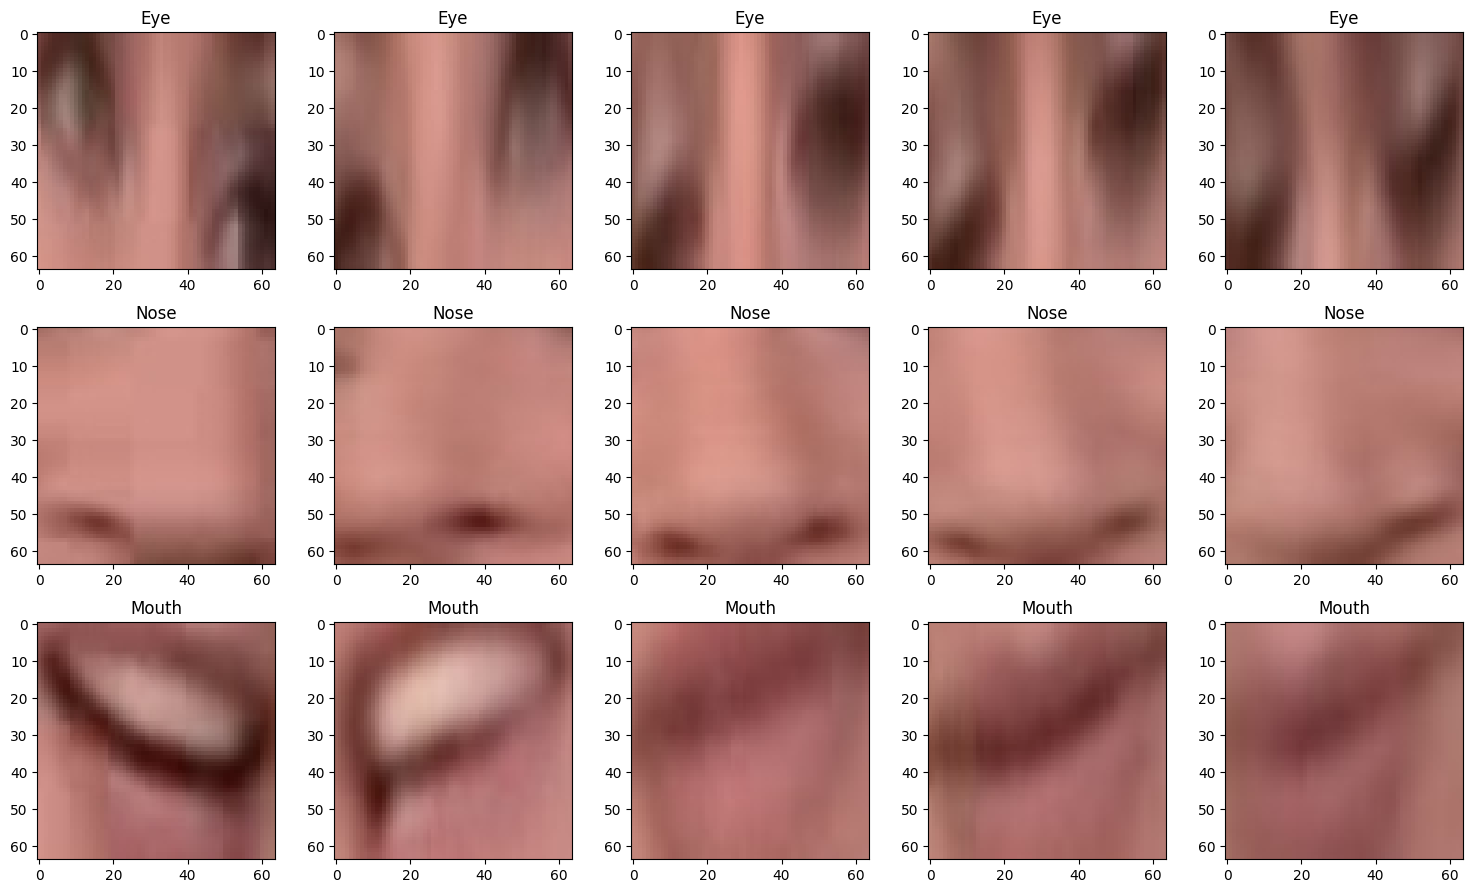

Verifica batch TEST:
  /content/ds_split/test_batches/batch_0.pkl: OK (100 video)


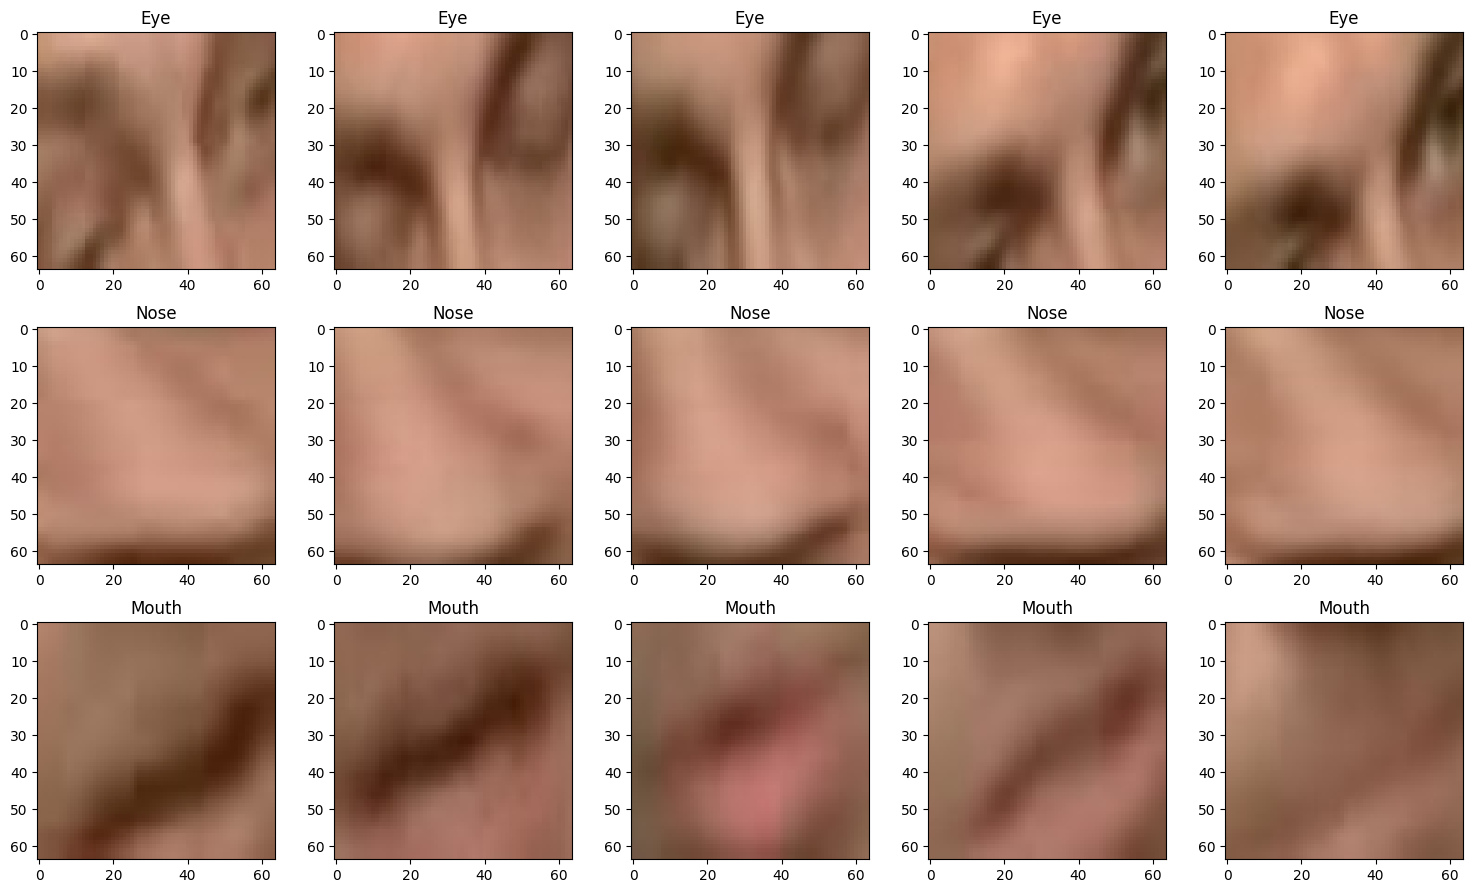

Verifica batch VAL:
  /content/ds_split/val_batches/batch_0.pkl: OK (100 video)


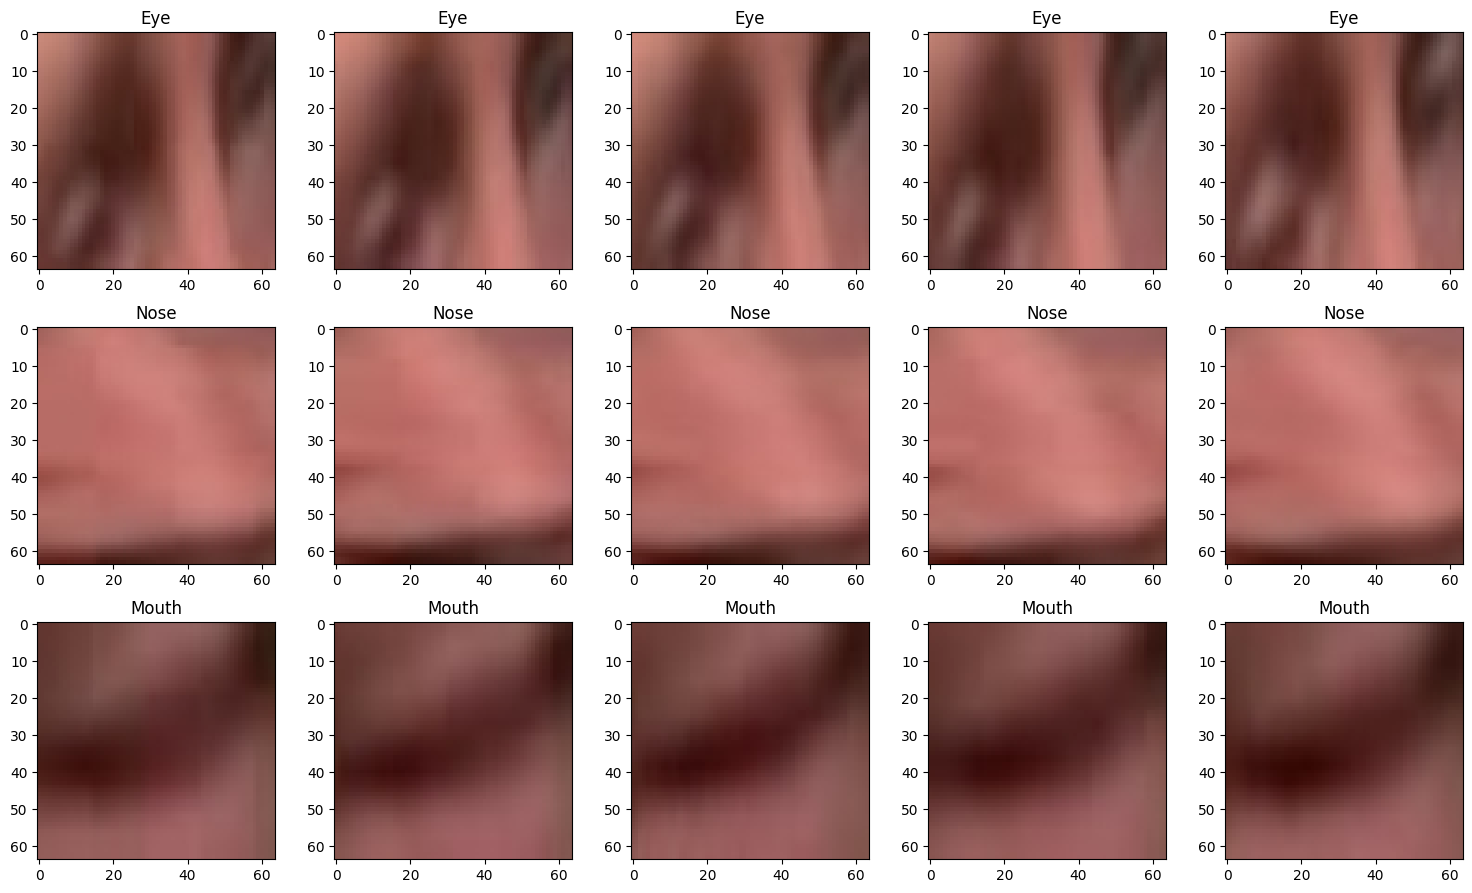

In [ ]:
# Main path
dataset_dir = "/content/ds_split"
batches_dir = {
    "train": os.path.join(dataset_dir, "train_batches"),
    "test": os.path.join(dataset_dir, "test_batches"),
    "val": os.path.join(dataset_dir, "val_batches")
}

# Function to verify each batch
def check_single_batch(batch_path):
    try:
        with open(batch_path, "rb") as f:
            batch = pickle.load(f)
        for video_data in batch:
            assert "video_name" in video_data
            assert "eyes" in video_data and "nose" in video_data and "mouth" in video_data
            assert "label" in video_data
            assert len(video_data["eyes"]) == 20
            assert len(video_data["nose"]) == 20
            assert len(video_data["mouth"]) == 20
            for roi in video_data["eyes"] + video_data["nose"] + video_data["mouth"]:
                assert roi.size() == torch.Size([3, 64, 64])  # Controlla la dimensione dei tensori
        return True, len(batch)
    except Exception as e:
        return False, str(e)

# Function to view casual images from batc
def visualize_images_from_batch(batch_path):
    with open(batch_path, "rb") as f:
        batch = pickle.load(f)
    video_data = batch[0]
    eyes = video_data["eyes"]
    nose = video_data["nose"]
    mouth = video_data["mouth"]

    # De-normalize for visualization
    def denormalize(tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return tensor * std + mean

    # View 5 images for each ROI
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    for i in range(5):
        axes[0, i].imshow(denormalize(eyes[i]).permute(1, 2, 0).numpy())
        axes[0, i].set_title("Eye")
        axes[1, i].imshow(denormalize(nose[i]).permute(1, 2, 0).numpy())
        axes[1, i].set_title("Nose")
        axes[2, i].imshow(denormalize(mouth[i]).permute(1, 2, 0).numpy())
        axes[2, i].set_title("Mouth")
    plt.tight_layout()
    plt.show()

# Paths to train, test and val batches
batch_paths = {
    "train": os.path.join(batches_dir["train"], "batch_0.pkl"),
    "test": os.path.join(batches_dir["test"], "batch_0.pkl"),
    "val": os.path.join(batches_dir["val"], "batch_0.pkl"),
}

# Verify and visual chek for each batch
for split, batch_path in batch_paths.items():
    print(f"Verifying batch {split.upper()}:")
    if os.path.exists(batch_path):
        valid, info = check_single_batch(batch_path)
        if valid:
            print(f"  {batch_path}: OK ({info} video)")
            visualize_images_from_batch(batch_path)  # Mostra le immagini
        else:
            print(f"  {batch_path}: ERROR ({info})")
    else:
        print(f"Batch {batch_path} unfound!")
